# Part II: Semi-supervised Low-level Segmentation

### Implementing interactive seed-based segmentation using s/t graph cut.
#### A basic seed-interactive GUI "GraphCutsPresenter" is available (implemented in "asg1.py"). The starter code below uses it. The presenter allows to add seeds (left and right mouse clicks for object and background seeds) and displays these seeds over the image. However, instead of proper graph cut segmentation the provided code displays some fixed binary mask (just as an example of a mask). This "fixed" mask should be replaced by the output of an interactive image segmentation method based on minimum s/t graph cut respecting the hard constraints marked by the user seeds. We use an existing python library for computing minimum s/t cuts on arbitrary graphs (run "$\text{pip install PyMaxFlow}$" in Anaconda Prompt, see <a href="http://pmneila.github.io/PyMaxflow/maxflow.html">documentation</a>). This library can build a weighted graph based on selected image and user-entered seeds.

#### First, we implement the most basic version of the graph cut algorithm for interactive image segmentation based on user seeds that minimizes the following weak-supervision loss  $$ -\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda \sum_{pq\in N} w_{pq}\,[S_p \neq S_q] $$ combining the supervision loss, a.k.a. seed loss (hard constraints for user-defined labels), and basic pair-wise regularization loss with "contrast-weights" $w_{pq} = \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ for 4-connected grid neighborhood. Note that the scalar (hyper-parameter) $\lambda$ controlling the regularization strength can be integrated into edge weights $\tilde{w}_{pq} = \lambda \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ (parameter $\lambda$ is primarily needed for the second milestone below). Terminal "t-links" for seed-points should make sure that such graph nodes can not be severed from the corresponding terminals. We have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. One can argue that $N\cdot \max \{\tilde{w}_{pq}\}\equiv N\lambda$ (where N is the number of neighbors at each point) is sufficient.

#### Our second task is to add color-based negative log-likelihoods (NLL), into the total loss $$ -\sum_p \log Pr(I_p\,|\,\theta_{S_p}) \;\;-\;\;\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda\sum_{pq\in N} w_{pq}\,[S_p \neq S_q] $$ where two distinct color distributions $\Pr(I|\theta_1)$ and $\Pr(I|\theta_0)$ for two segments (object and backgound) should be estimated as GMMs from the corresponding seeds, as follows. GMM is a standard way to efficiently estimate arbitrary multi-modal probability density functions using relatively few parameters. Note that this project is not using GMMs to cluster seeds or any other pixels. We estimate one set of parameters $\theta_1$ for the GMM probability denisty function $\Pr(I|\theta_1)$ for RGB colors at pixels with "red" seeds (treated as a sample of object features), and the second set of parameters $\theta_0$ of the GMM probability density function $\Pr(I|\theta_0)$  for RGB colors at pixels with "blue" seeds (sample of background features). We use the "GaussianMixture" function from the standard "mixture" library in "sklearn"; mixtures of six Gaussian modes ($K=6$) suffices for each GMM density. After estimating two color distributions/densities (from seeds), then we can evaluate two likelihoods $\Pr(I_p|\theta_1)$ and $\Pr(I_p|\theta_0)$ at any pixel $p$, as required for the color log-likelihoods term in the total loss above.

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# loading standard library for GMM estimation
from sklearn.mixture import GaussianMixture

# loading standard maxflow library (graph cuts)
# Before importing maxflow first time, you must "pip install PyMaxflow" in Anaconda Prompt (see https://pypi.org/project/PyMaxflow/) 
import maxflow

# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1_error_handling import Figure, GraphCutsPresenter

In [ ]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img, reg=100, var=0.05):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]

        self.img = img / np.max(img)
        self.reg = 100 # lambda
        self.var = 0.05 # sigma

    def run(self):
        self.fig.show()


    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols

        # four direction edge weight (n-links)
        n_right = self.reg * np.exp(- np.linalg.norm(self.img - np.roll(self.img, shift=-1, axis=1), axis=-1)**2 / (2 * self.var**2))
        n_below = self.reg * np.exp(- np.linalg.norm(self.img - np.roll(self.img, shift=-1, axis=0), axis=-1)**2 / (2 * self.var**2))

        g = maxflow.GraphFloat()

        node_ids = g.add_grid_nodes((num_rows, num_cols))
        structure_x = np.array([[0,0,0],[0,0,1],[0,0,0]])
        structure_y = np.array([[0,0,0],[0,0,0],[0,1,0]])
        g.add_grid_edges(node_ids, weights=n_right, structure=structure_x, symmetric=True)
        g.add_grid_edges(node_ids, weights=n_below, structure=structure_y, symmetric=True)

        # seed value edge weights (t-links)
        bgr_mask = (seed_mask == self.bgr_value)
        obj_mask = (seed_mask == self.obj_value)

        t_source = np.zeros((num_rows, num_cols))
        t_sink = np.zeros((num_rows, num_cols))

        t_source[bgr_mask] = 4 * self.reg
        t_sink[obj_mask] = 4 * self.reg

        # incorporate Gaussian mixture model
        if np.count_nonzero(bgr_mask) > 1 and np.count_nonzero(obj_mask) > 1:
            gmm_bgr = GaussianMixture(n_components=6)
            gmm_obj = GaussianMixture(n_components=6)

            gmm_bgr.fit(self.img[bgr_mask].reshape(-1, 3))
            gmm_obj.fit(self.img[obj_mask].reshape(-1, 3))

            ll_bgr = gmm_bgr.score_samples(self.img.reshape(-1, 3)).reshape((num_rows, num_cols))
            ll_obj = gmm_obj.score_samples(self.img.reshape(-1, 3)).reshape((num_rows, num_cols))

            g.add_grid_tedges(node_ids, ll_bgr + t_source, ll_obj + t_sink)
        
        else:
            g.add_grid_tedges(node_ids, t_source, t_sink)

        g.maxflow()

        label_mask = g.get_grid_segments(node_ids)

        return label_mask

### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

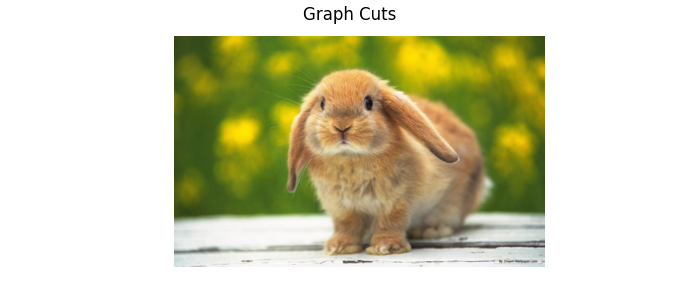

In [ ]:
img1 = plt.imread('images/bunny.bmp')
app = MyGraphCuts(img1, reg=100, var=0.05)
app.run()

<img src="images/Figure 22.png" width="875" height="375">

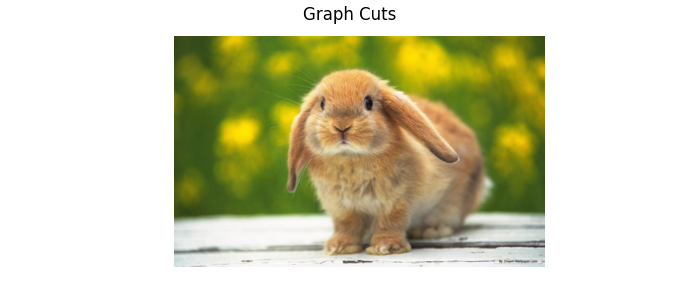

In [ ]:
img1 = plt.imread('images/bunny.bmp')
app = MyGraphCuts(img1, reg=0.05, var=5)
app.run()

<img src="images/Figure 23.png" width="875" height="375">

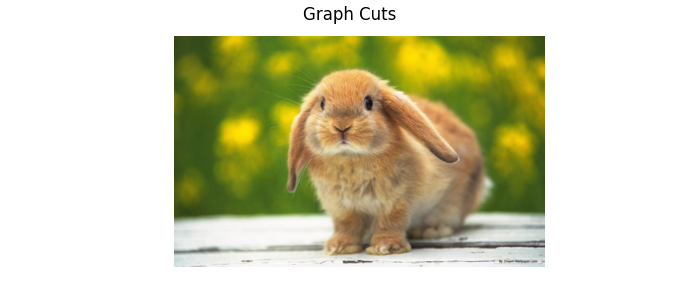

In [ ]:
img1 = plt.imread('images/bunny.bmp')
app = MyGraphCuts(img1, reg=1, var=0.2)
app.run()

<img src="images/Figure 24.png" width="875" height="375">

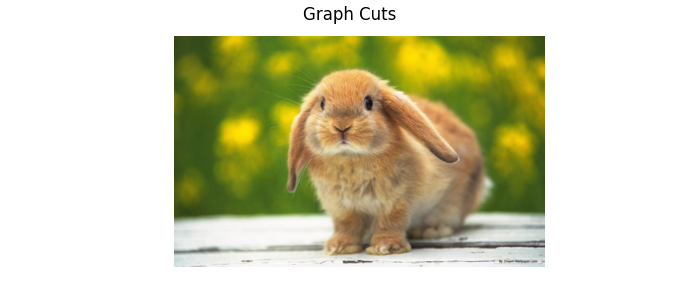

In [ ]:
img1 = plt.imread('images/bunny.bmp')
app = MyGraphCuts(img1, reg=50, var=2)
app.run()

<img src="images/Figure 25.png" width="875" height="375">

For smaller values of $\sigma$, there was higher sensitivity to intensity differences. For $\sigma=0.05, 0.2$, the small intensity changes created by the contours of the bunny are flagged as background. Similarly, small changes in colour in the background lead to discontinuity in the segmentation. When we set $\sigma=5$, the segmentation becomes too insensitive and major sections of the bunny get labeled as background. In the end the best choice was in the middle with $\sigma = 2$.

To adaptively select $\sigma$, we start with small $\sigma$ and increase it if there are large intensity differences and thus higher entropy. By increasing $\sigma$, we decrease the sensitivity which will lead to smoother segmentation.

### Show how your interactive segmenter works on more challanging images where there is some overlap between the color-models in the object and background (as in the "lama" image). Compare the results for $\lambda=0$ (no regularization) and for some $\lambda>0$. For convenience, you might want to include $\lambda$ in the list of parameters for the function "MyGraphcuts".

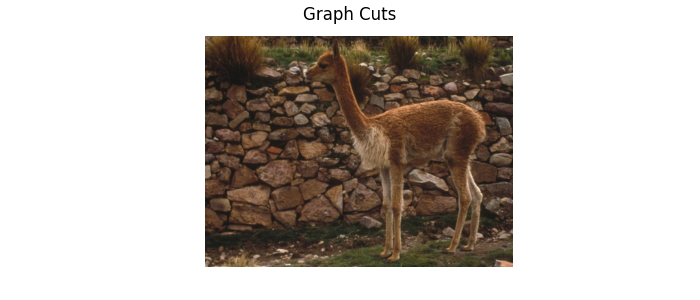

In [ ]:
img2 = plt.imread('images/lama.jpg')
app = MyGraphCuts(img2, reg=0)
app.run()

<img src="images/Figure 26.png" width="875" height="375">

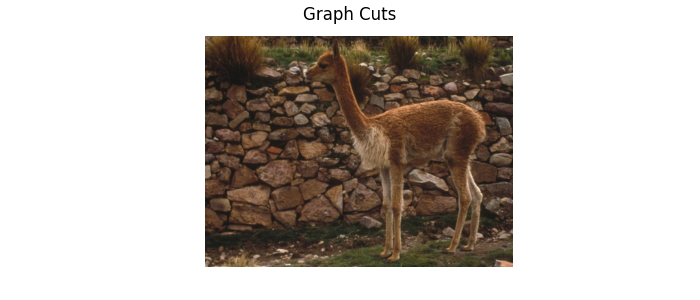

In [ ]:
img2 = plt.imread('images/lama.jpg')
app = MyGraphCuts(img2, reg=5)
app.run()

<img src="images/Figure 27.png" width="875" height="375">

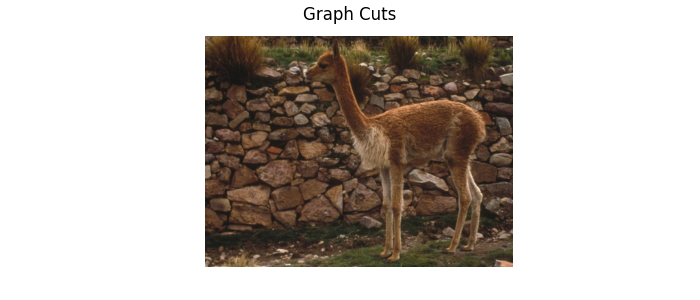

In [ ]:
img2 = plt.imread('images/lama.jpg')
app = MyGraphCuts(img2, reg=100)
app.run()

<img src="images/Figure 28.png" width="875" height="375">

For $\lambda = 0, 5$, the segmentation has a lot more discontinuities. However for $\lambda = 100$, the segmentation between the background and the llama is more clear. This is because for higher $\lambda$, we put more emphasis on the region growing section of our formula (i.e. minimizing discontinuities in the segmentation). As a result we are less sensitive to changes in intensity and prioritize the information given by surrounding pixels. So for lower $\lambda$ value we segment lower level features determined by rgb values, but for higher $\lambda$ we get a cleaner separation between the llama and the background. 